In [79]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj, coalesce, to_undirected, remove_self_loops
from vitRet.data.segmentation import MaplesDR
from vitRet.models.prototypes_vit.utils import consecutive_reindex_batch_of_integers_tensor
import numpy as np

from vitRet.models.prototypes_vit.affinity_pooling import AffinityPooling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


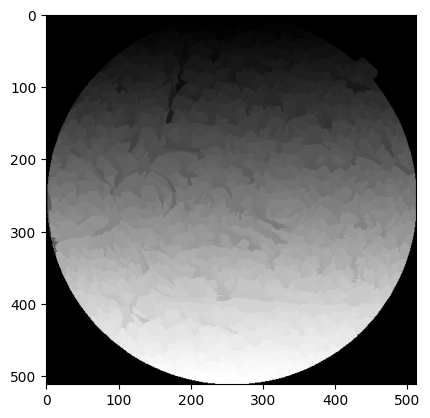

In [142]:
datamodule = MaplesDR("/home/clement/Documents/data/Maples-DR/", num_workers=4, batch_size=3, superpixels_nb=2048, superpixels_min_size_factor=1)
datamodule.setup("test")
dataloader = datamodule.test_dataloader()
batch = next(iter(dataloader))
segments = batch['segments']
segments = segments.unsqueeze(1)
segments = consecutive_reindex_batch_of_integers_tensor(segments)
plt.imshow(segments[0, 0].numpy())
plt.show()

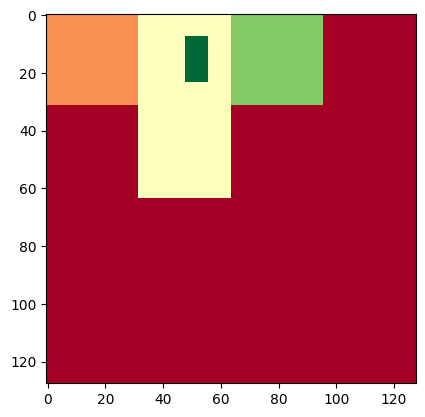

In [110]:
segments = torch.zeros((3,1,128,128))
segments[1,:, :32, :32] = 1
segments[1,:, :64, 32:64] = 2
segments[1,:, :32, 64:96] = 3

segments[1,:, 8:24, 48:56] = 4



plt.imshow(segments[1, 0], cmap='RdYlGn', interpolation='nearest')
plt.show()

In [13]:
def get_super_adjacency(segments:torch.Tensor, keep_self_loops:bool=False):
    """
    Return the adjacency matrix for the segments map. 
    Each value of the adjacency matrix corresponds to the number neighboring of pixels 
    Note that that there is an ambiguity for pixels in the image's border. 
    By default, we pad the image.
    segments: tensor (type int64) of shape BxWxH
    """
    # Maximum number of segments in the batch
    n_segments = torch.amax(segments) + 1
    
    b = segments.shape[0]
    
    segments_per_image = (torch.amax(segments, dim=(1,2,3)) + 1).long()
    
    cum_sum = torch.cumsum(segments_per_image, -1)
    cum_sum = torch.roll(cum_sum, 1)
    cum_sum[0] = 0 
    
    # We reindex each segment in increasing order along the batch dimension
    indexed_segments = segments + cum_sum.view(-1, 1, 1, 1)
    
    # For each pixel, this kernel extracts its neighbours (connectivity 4)
    kernel = torch.zeros(4,1,2,2, device=segments.device, dtype=torch.float)
    kernel[0,:,0, 0] = 1
    kernel[1,:,0, 1] = 1
    kernel[2,:,0, 0] = 1
    kernel[3,:,1, 0] = 1
    indexed_segments = F.pad(indexed_segments, (0, 1, 0, 1), mode='reflect')
    neighbours = F.conv2d(indexed_segments.float(), kernel)
    
    # For each segment, we track its batch position
    batch_index = torch.arange(0, b).repeat_interleave(segments_per_image)
    
    def adj_from_edge_index(edge_index):
        if not keep_self_loops:
            edge_index, _ = remove_self_loops(edge_index=edge_index)
        adj = to_dense_adj(edge_index, 
                        batch=batch_index, 
                        batch_size=b, 
                        max_num_nodes=int(n_segments))
        adj = (adj + adj.permute(0,2,1)) / 2
        if keep_self_loops:
            diag = torch.diagonal(adj, dim1=-2, dim2=-1)
            diag /= 2
        return adj
    
    edge_index_horizontal = neighbours.permute(1,0,2,3)[:2].reshape(2, -1).long()
    edge_index_vertical = neighbours.permute(1,0,2,3)[2:].reshape(2, -1).long()
    
    edge_index = torch.cat([edge_index_horizontal, edge_index_vertical], 1)
    # 2 x 2*n_edges (H-1 x W-1)
    
    adj = adj_from_edge_index(edge_index)
    return adj, edge_index


adj, edge_index = get_super_adjacency(segments=segments, keep_self_loops=True)

In [15]:
adj[1]

tensor([[12272.,    16.,    48.,    32.,     0.],
        [   16.,   992.,    16.,     0.,     0.],
        [   48.,    16.,  1860.,    16.,    24.],
        [   32.,     0.,    16.,   992.,     0.],
        [    0.,     0.,    24.,     0.,   116.]])

In [143]:
adj_bis = AffinityPooling._compute_proximity_adjacency(segments, normalize=False)
adj_bis[1]

tensor([[5.4956e+04, 8.0000e+00, 5.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0000e+00, 3.6000e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [148]:
(segments[1]==81).sum()

tensor(1)

In [147]:
segments[1].unique(return_counts=True)[1].argmin()

tensor(81)